In [1]:
import pandas as pd
import numpy as np
import holidays
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8')

In [2]:
ts_df = pd.read_csv('required_dataset.csv')

In [3]:
shifted_rolling = ts_df['quantity'].shift(1).rolling(window=5).mean()
ceiling_rolling = np.ceil(shifted_rolling)

ts_df['quantity'] = np.where(ts_df['quantity'] == 0, 0, ceiling_rolling)
ts_df['quantity'] = ts_df['quantity'].bfill().ffill()
ts_df['quantity'] = ts_df['quantity'].astype(int)


Feature Engineering

In [ ]:
def create_daily_features(df):
    df = df.copy()
    df['lag_1'] = df['quantity'].shift(1)
    df['lag_2'] = df['quantity'].shift(2)
    df['lag_7'] = df['quantity'].shift(7)
    df['roll_mean_3'] = df['quantity'].shift(1).rolling(window=3).mean()
    df['roll_mean_7'] = df['quantity'].shift(1).rolling(window=7).mean()
    df['roll_mean_14'] = df['quantity'].shift(1).rolling(window=14).mean()
    df['dayofweek'] = df.index.dayofweek
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    df['month'] = df.index.month
    df['quarter'] = df.index.quarter
    df['is_month_start'] = df.index.is_month_start.astype(int)
    df['is_month_end'] = df.index.is_month_end.astype(int)
    df['is_weekend'] = (df.index.dayofweek >= 5).astype(int)
    years = df.index.year.unique()
    ind_holidays = holidays.India(years=years)
    holiday_dates = pd.to_datetime(list(ind_holidays.keys()))
    df['is_holiday'] = df.index.isin(holiday_dates).astype(int)
    df['days_since_last_holiday'] = (df.index.to_series().map(lambda d: (d - holiday_dates[holiday_dates <= d].max()) if any(holiday_dates <= d) else pd.Timedelta('365D'))).dt.days
    df['days_to_next_holiday'] = (df.index.to_series().map(lambda d: (holiday_dates[holiday_dates >= d].min() - d) if any(holiday_dates >= d) else pd.Timedelta('365D'))).dt.days
    df['lag_1_discount'] = df['lag_1'] * df['discount']
    df.fillna(0, inplace=True)
    return df

Evaluation Metrics

In [5]:
def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

Selecting Top 10 Products

In [6]:
ts_df['order_date'] = pd.to_datetime(ts_df['order_date'])
top_products = ts_df.groupby('ean_code')['quantity'].sum().nlargest(10).index.tolist()
results = []

Model Selection, Validation and Prediction

Validation metrics for EAN 8904362500005:
Random Forest - MAE: 75.72, RMSE: 163.13, R2: 0.981
XGBoost - MAE: 70.66, RMSE: 98.11, R2: 0.993
Linear Regression - MAE: 162.36, RMSE: 312.89, R2: 0.931


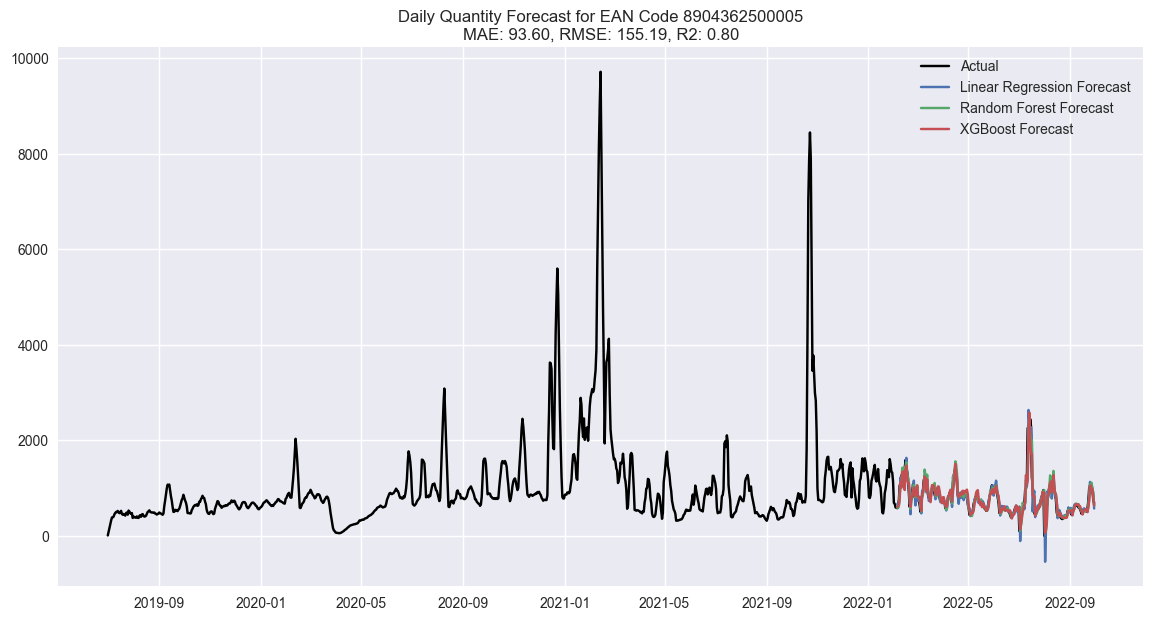

Validation metrics for EAN 8904362502719:
Random Forest - MAE: 24.23, RMSE: 49.57, R2: 0.958
XGBoost - MAE: 2.77, RMSE: 3.72, R2: 1.000
Linear Regression - MAE: 43.54, RMSE: 105.76, R2: 0.811


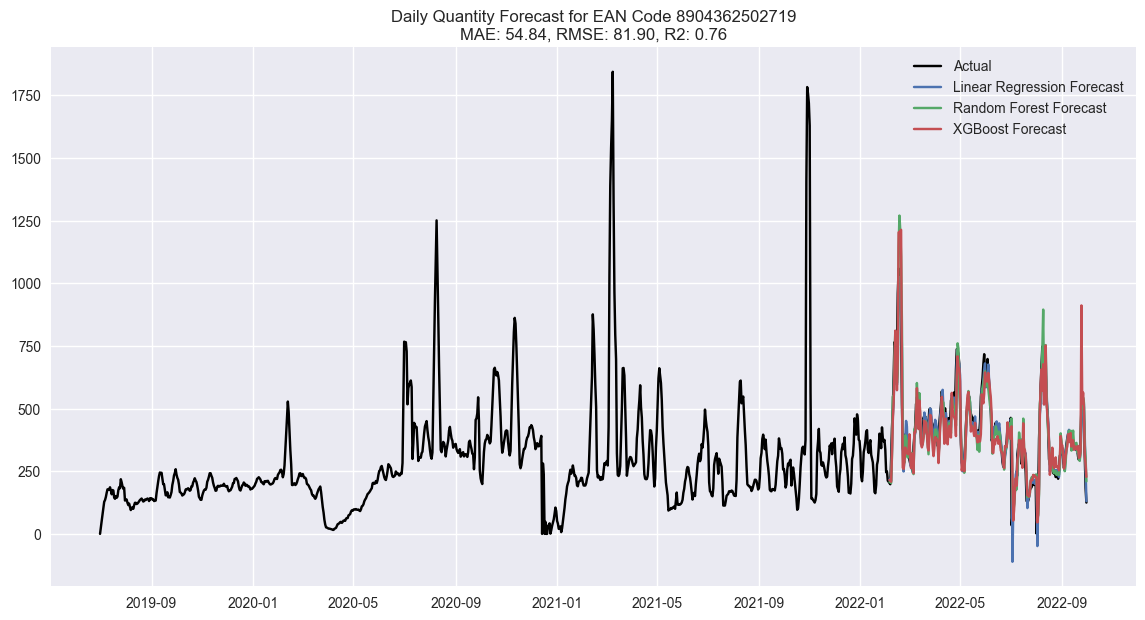

Validation metrics for EAN 8904352001642:
Random Forest - MAE: 6.73, RMSE: 9.12, R2: 0.989
XGBoost - MAE: 11.86, RMSE: 15.19, R2: 0.971
Linear Regression - MAE: 15.72, RMSE: 20.45, R2: 0.947


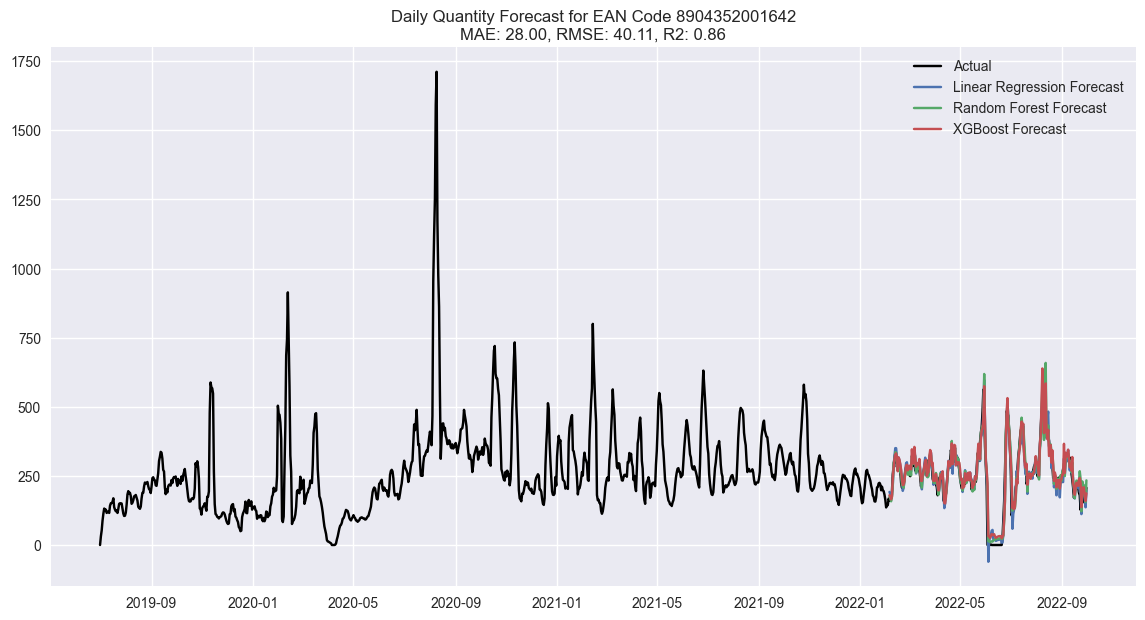

Validation metrics for EAN 806360320204:
Random Forest - MAE: 44.43, RMSE: 61.21, R2: 0.907
XGBoost - MAE: 53.05, RMSE: 75.72, R2: 0.857
Linear Regression - MAE: 55.20, RMSE: 87.12, R2: 0.811


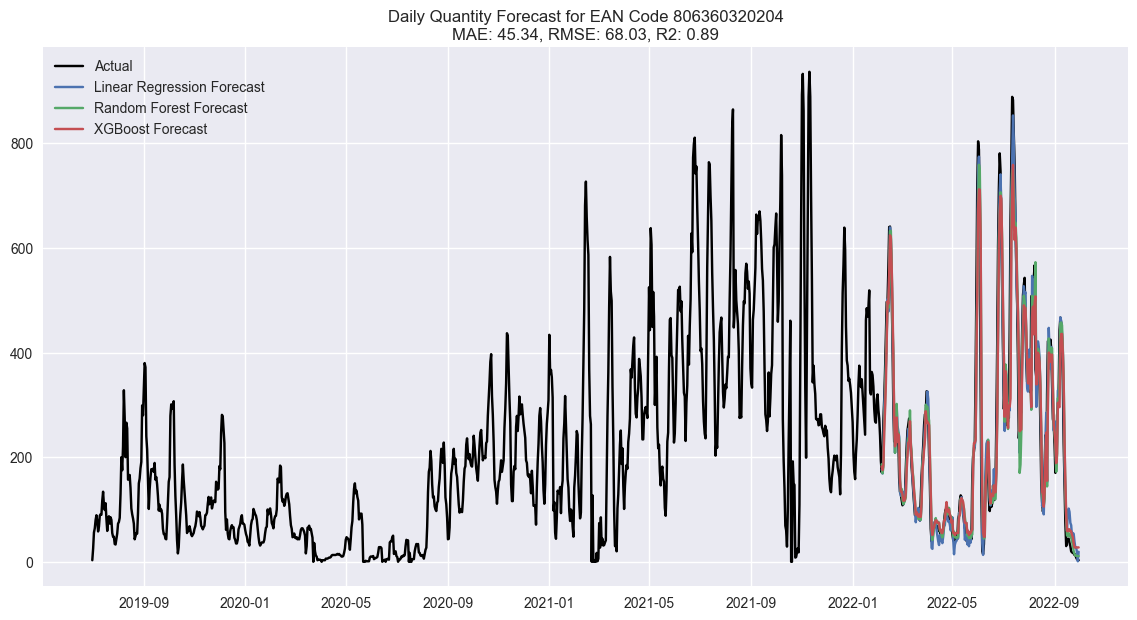

Validation metrics for EAN PPLP1214AG3:
Random Forest - MAE: 7.19, RMSE: 13.16, R2: 0.972
XGBoost - MAE: 0.06, RMSE: 0.08, R2: 1.000
Linear Regression - MAE: 19.58, RMSE: 38.02, R2: 0.769


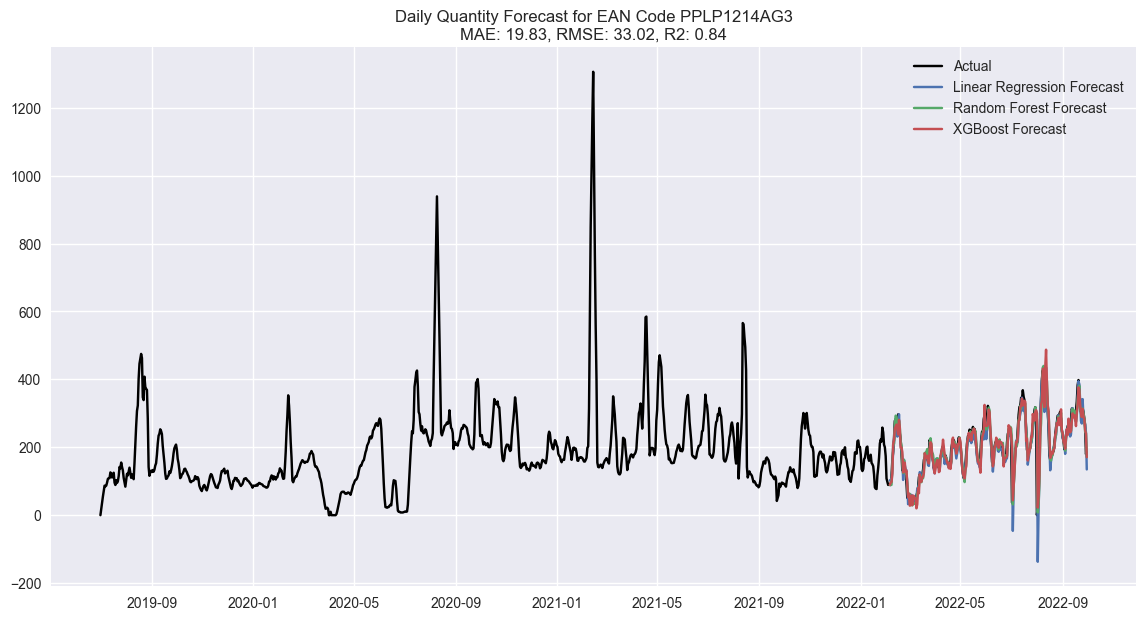

Validation metrics for EAN 6902395722434:
Random Forest - MAE: 35.24, RMSE: 57.32, R2: 0.970
XGBoost - MAE: 0.04, RMSE: 0.06, R2: 1.000
Linear Regression - MAE: 43.85, RMSE: 68.22, R2: 0.957


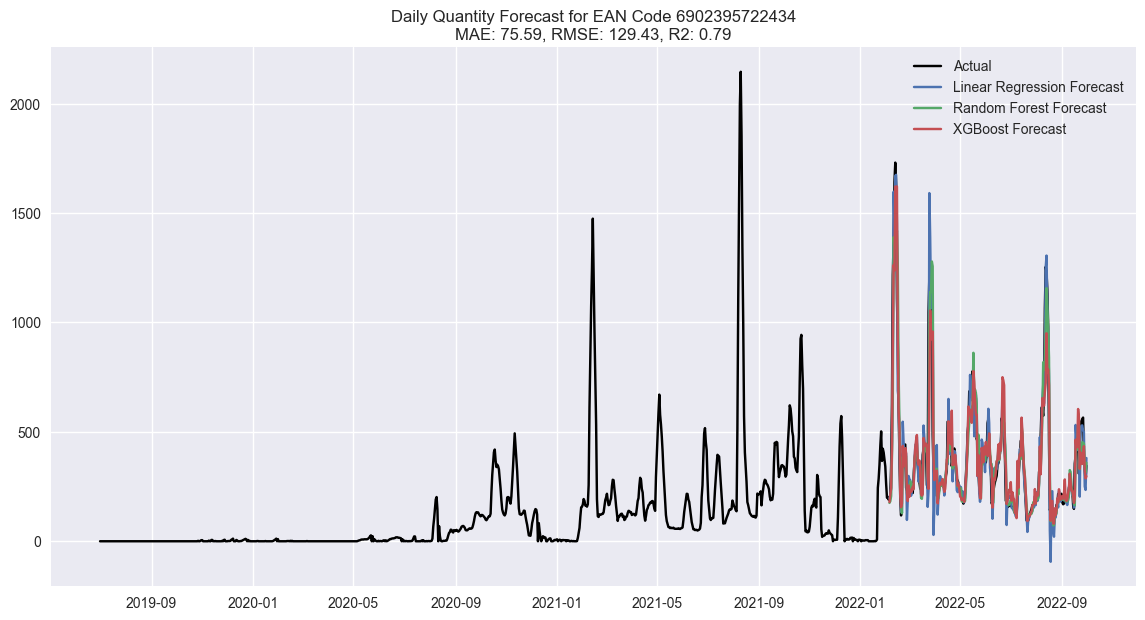

Validation metrics for EAN NYBLE001:
Random Forest - MAE: 5.38, RMSE: 7.94, R2: 0.995
XGBoost - MAE: 0.10, RMSE: 0.15, R2: 1.000
Linear Regression - MAE: 15.15, RMSE: 21.35, R2: 0.964


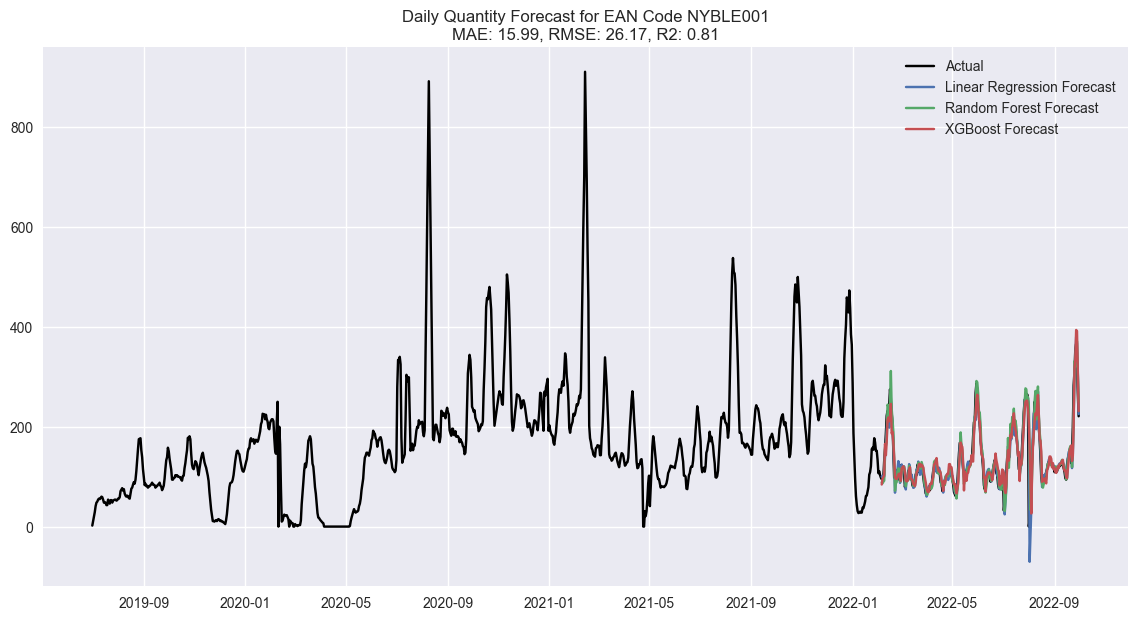

Validation metrics for EAN 8904362502993:
Random Forest - MAE: 14.88, RMSE: 27.39, R2: 0.965
XGBoost - MAE: 16.42, RMSE: 22.85, R2: 0.975
Linear Regression - MAE: 27.63, RMSE: 49.88, R2: 0.882


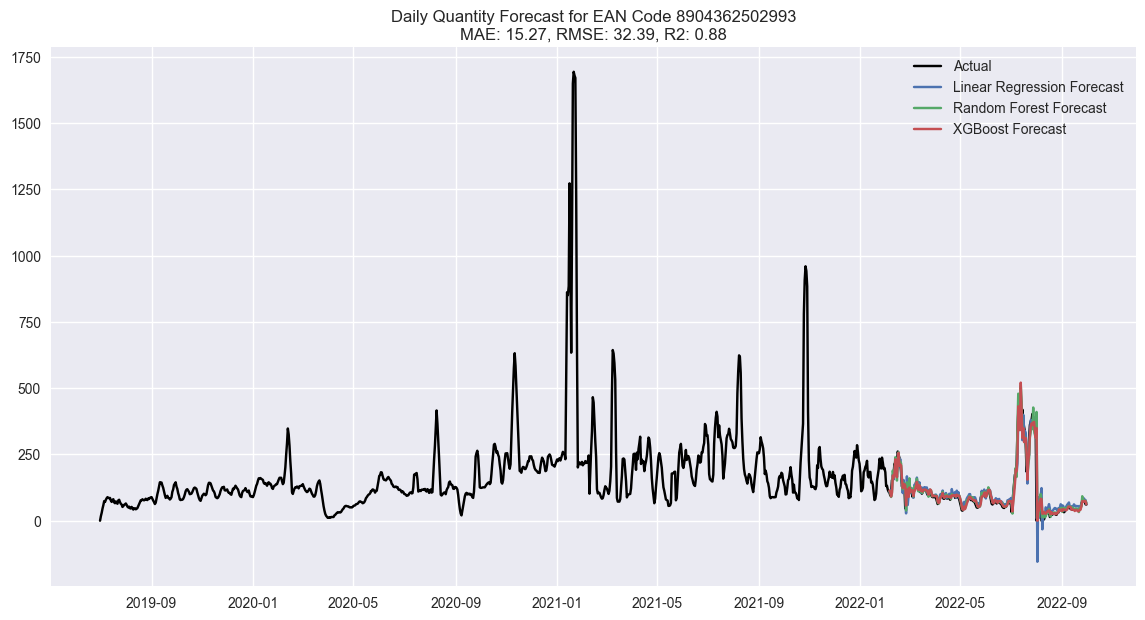

Validation metrics for EAN 8904362500012:
Random Forest - MAE: 7.18, RMSE: 11.10, R2: 0.968
XGBoost - MAE: 12.47, RMSE: 18.76, R2: 0.909
Linear Regression - MAE: 16.75, RMSE: 27.32, R2: 0.808


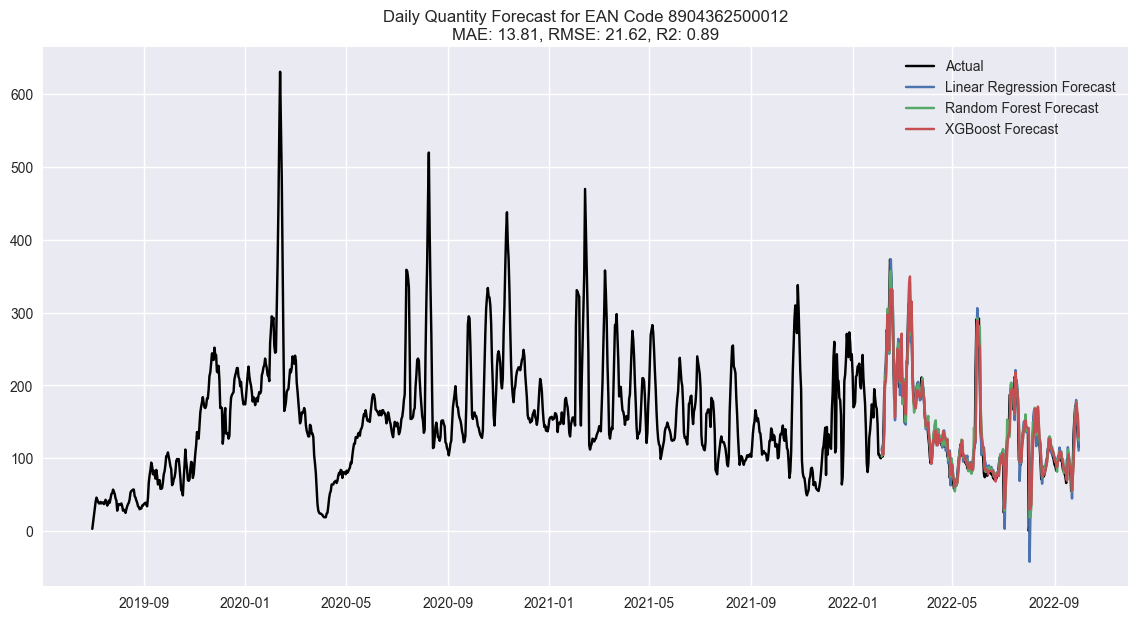

Validation metrics for EAN 6902395722403:
Random Forest - MAE: 40.67, RMSE: 63.31, R2: 0.952
XGBoost - MAE: 0.00, RMSE: 0.00, R2: 1.000
Linear Regression - MAE: 59.81, RMSE: 114.16, R2: 0.844


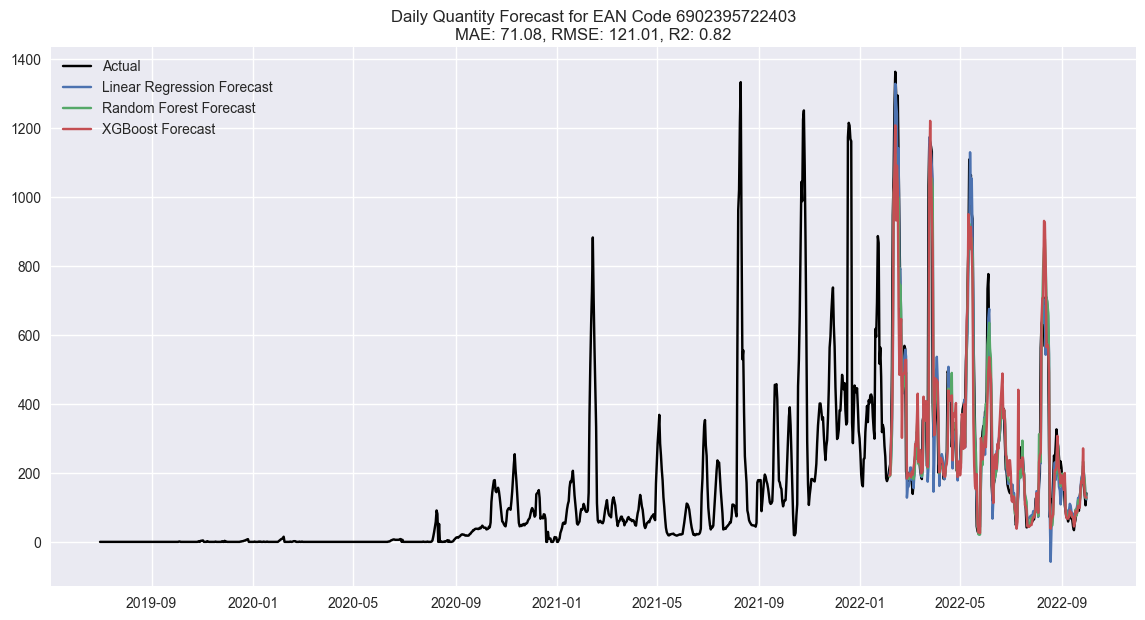

In [8]:
for product in top_products:
    df_prod = ts_df[ts_df['ean_code'] == product].copy()
    df_prod['day_start'] = df_prod['order_date'].dt.floor('D')
    df_daily = df_prod.groupby('day_start').agg({'quantity': 'sum', 'discount': 'median'})
    df_daily.index = pd.to_datetime(df_daily.index)
    df_daily = create_daily_features(df_daily)

    train_size = int(len(df_daily) * 0.8)
    train = df_daily.iloc[:train_size]
    test = df_daily.iloc[train_size:]
    train_ml = train.copy()
    test_ml = test.copy()
    val_size = int(len(train_ml) * 0.2)
    train_final = train_ml.iloc[:-val_size]
    val = train_ml.iloc[-val_size:]
    features = ['lag_1', 'lag_2', 'lag_7', 'roll_mean_3', 'roll_mean_7', 'roll_mean_14', 'dayofweek', 'dayofmonth', 'weekofyear', 'month', 'quarter', 'is_month_start', 'is_month_end', 'is_weekend', 'is_holiday', 'days_since_last_holiday', 'days_to_next_holiday', 'discount', 'lag_1_discount']

    
    param_grid_rf = {
        'n_estimators': [100, 300],
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 5]
    }
    tscv = TimeSeriesSplit(n_splits=3)
    grid_search_rf = GridSearchCV(RandomForestRegressor(random_state=0), param_grid_rf, cv=tscv, scoring='neg_mean_squared_error')
    grid_search_rf.fit(train_ml[features], train_ml['quantity'])
    best_rf = grid_search_rf.best_estimator_
    rf_pred = best_rf.predict(test_ml[features])

    
    param_grid_xgb = {
        'n_estimators': [100, 300],
        'max_depth': [3, 6, 9],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    grid_search_xgb = GridSearchCV(
        xgb.XGBRegressor(objective='reg:squarederror', random_state=0),
        param_grid_xgb, cv=tscv, scoring='neg_mean_squared_error'
    )
    grid_search_xgb.fit(train_ml[features], train_ml['quantity'])
    best_xgb = grid_search_xgb.best_estimator_
    xgb_pred = best_xgb.predict(test_ml[features])

    
    lr = LinearRegression().fit(train_ml[features], train_ml['quantity'])
    lr_pred = lr.predict(test_ml[features])

    
    rf_val_pred = best_rf.predict(val[features])
    xgb_val_pred = best_xgb.predict(val[features])
    lr_val_pred = lr.predict(val[features])

    
    y_val_true = val['quantity']
    print(f"Validation metrics for EAN {product}:")
    for name, pred in [('Random Forest', rf_val_pred), ('XGBoost', xgb_val_pred), ('Linear Regression', lr_val_pred)]:
        mae, rmse, r2 = evaluate(y_val_true, pred)
        print(f"{name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.3f}")

    y_true = test_ml['quantity']

    for model_name, pred in [('Linear Regression', lr_pred), ('Random Forest', rf_pred), ('XGBoost', xgb_pred)]:
        mae, rmse, r2 = evaluate(y_true, pred)
        results.append({'EAN_Code': product, 'Model': model_name, 'MAE': mae, 'RMSE': rmse, 'R2': r2})

    
    plt.figure(figsize=(14,7))
    all_actuals = pd.concat([train['quantity'], test['quantity']])
    plt.plot(all_actuals.index, all_actuals, label='Actual', color='black')
    # plt.axvline(x=test.index, color='grey', linestyle='--', alpha=0.5)
    plt.plot(test_ml.index, lr_pred, label='Linear Regression Forecast')
    plt.plot(test_ml.index, rf_pred, label='Random Forest Forecast')
    plt.plot(test_ml.index, xgb_pred, label='XGBoost Forecast')
    plt.title(f'Daily Quantity Forecast for EAN Code {product}\nMAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.2f}')
    plt.legend()
    plt.show()

In [9]:
results_df = pd.DataFrame(results)
print(results_df)

         EAN_Code              Model        MAE        RMSE        R2
0   8904362500005  Linear Regression  94.842675  163.084757  0.776381
1   8904362500005      Random Forest  86.743226  152.359727  0.804825
2   8904362500005            XGBoost  93.601692  155.192905  0.797499
3   8904362500005  Linear Regression  94.842675  163.084757  0.776381
4   8904362500005      Random Forest  86.743226  152.359727  0.804825
5   8904362500005            XGBoost  93.601692  155.192905  0.797499
6   8904362502719  Linear Regression  38.494536   60.701230  0.869640
7   8904362502719      Random Forest  48.275807   75.503167  0.798312
8   8904362502719            XGBoost  54.837101   81.902119  0.762677
9   8904352001642  Linear Regression  26.109194   34.743560  0.894293
10  8904352001642      Random Forest  26.409634   40.451464  0.856707
11  8904352001642            XGBoost  27.998369   40.109609  0.859119
12   806360320204  Linear Regression  34.764838   51.341801  0.936481
13   806360320204   

Plot For Accuracy Comparison of Top 10 Products

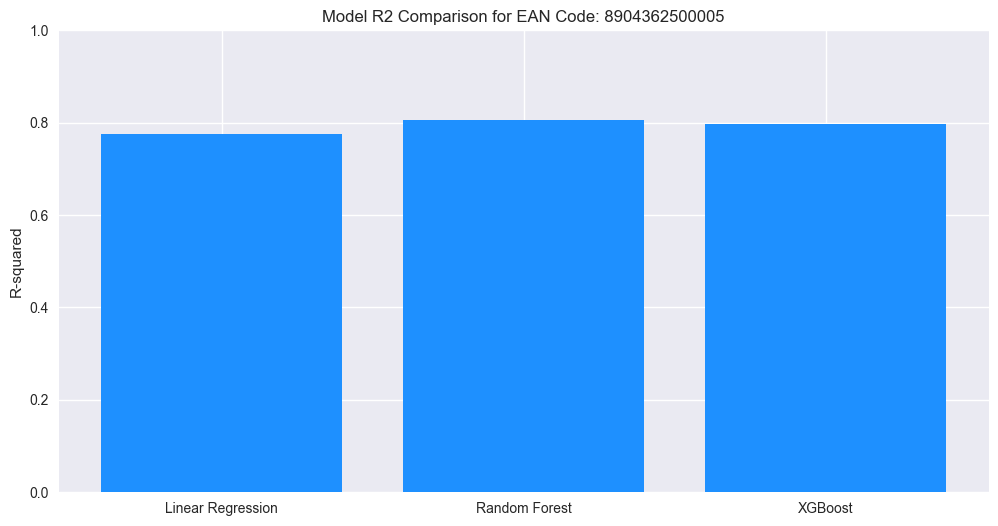

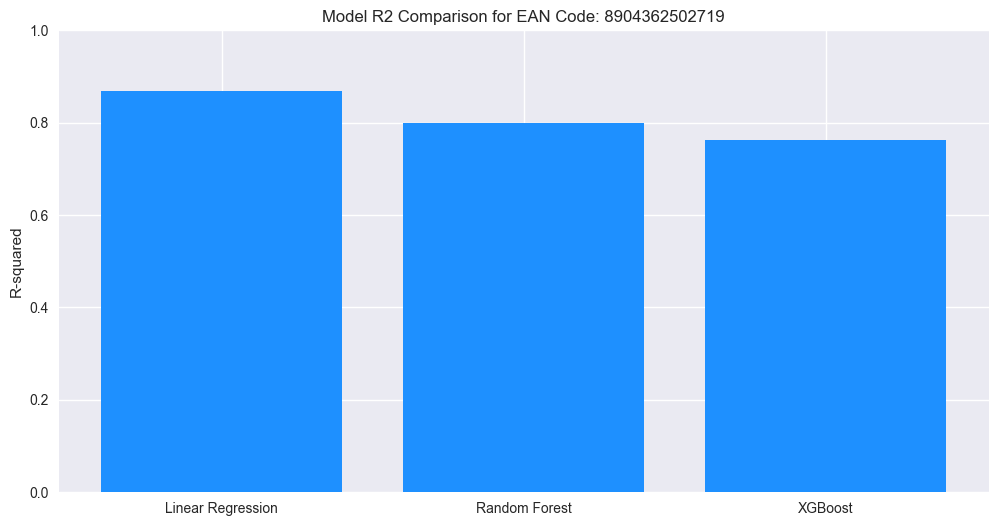

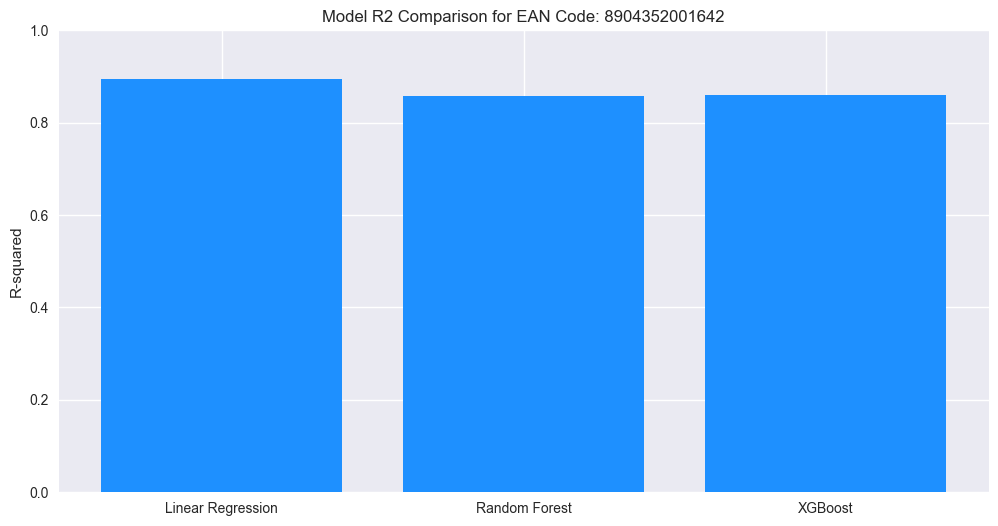

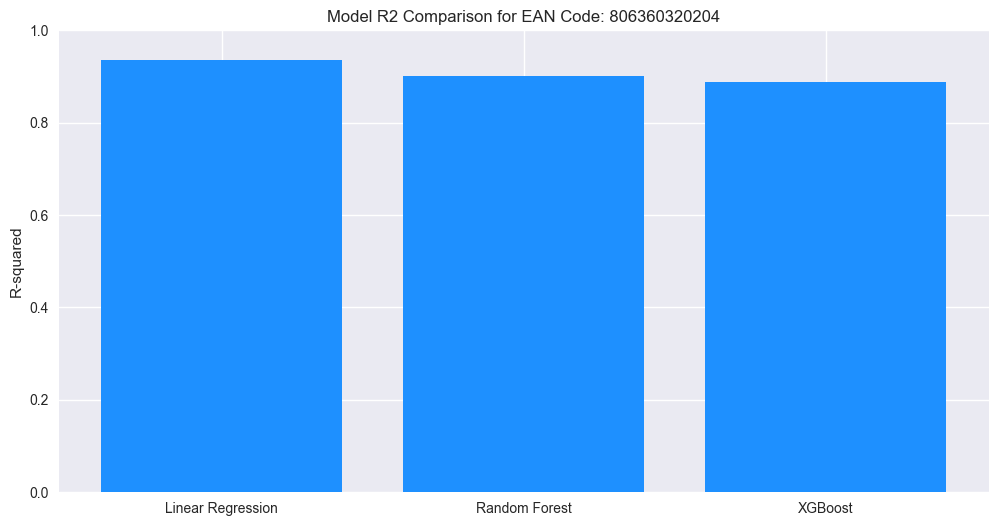

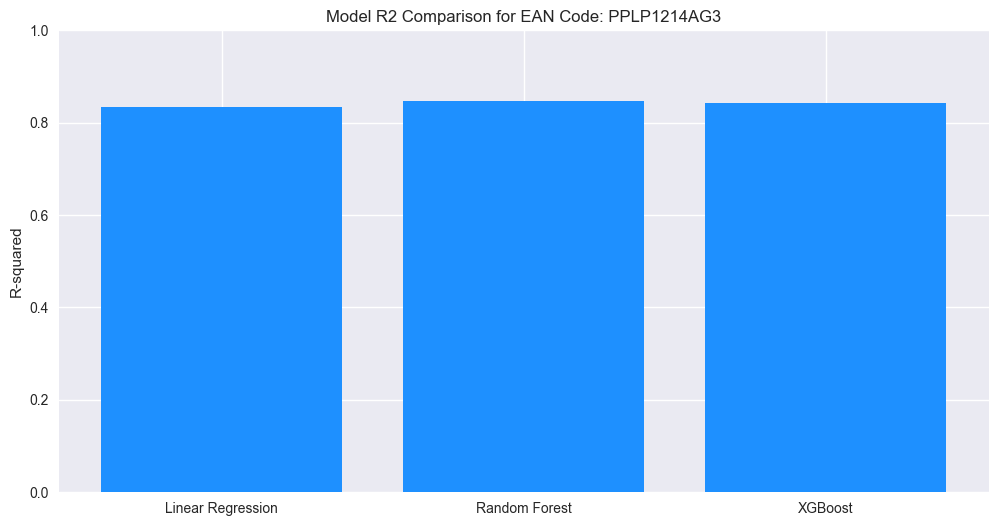

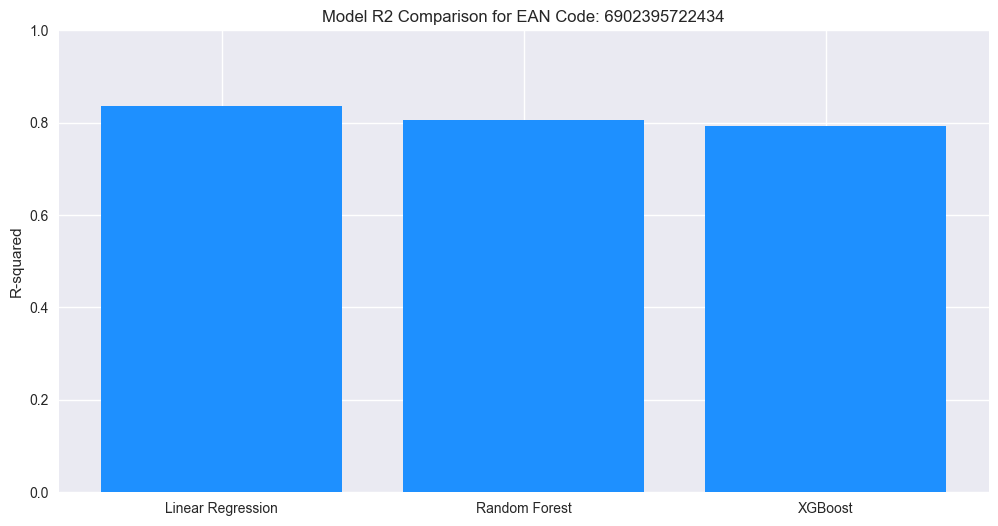

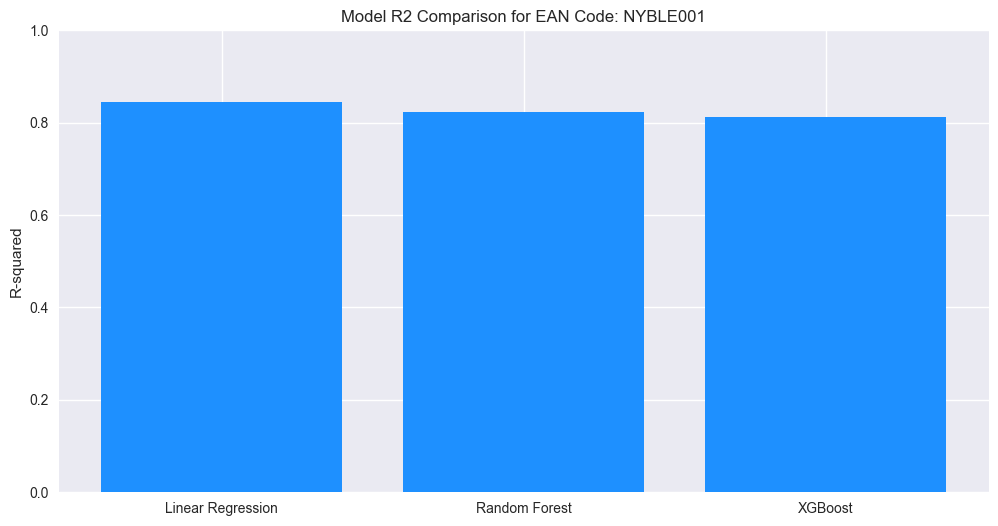

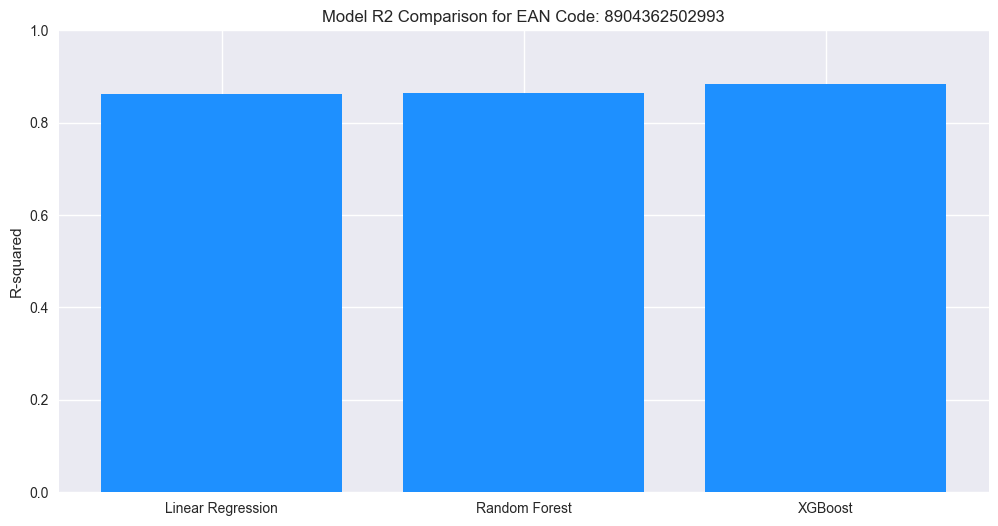

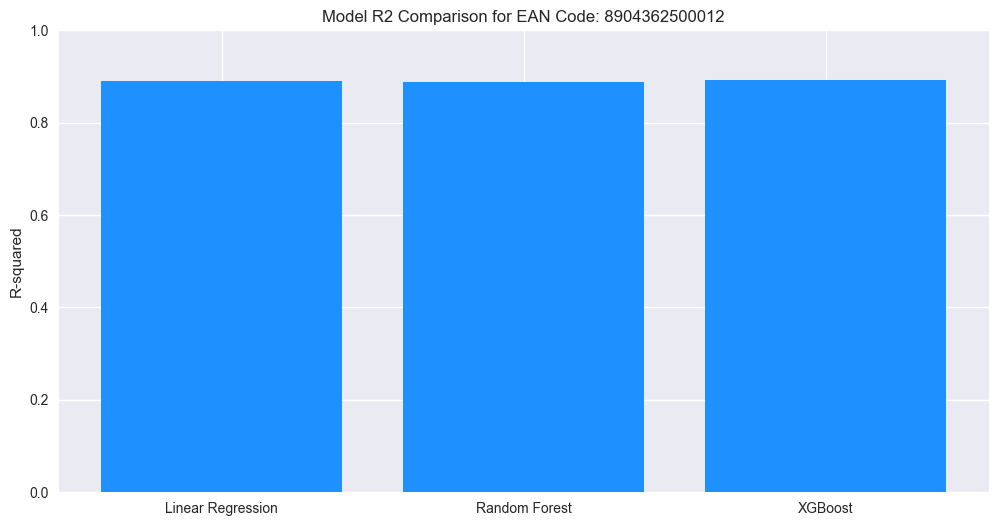

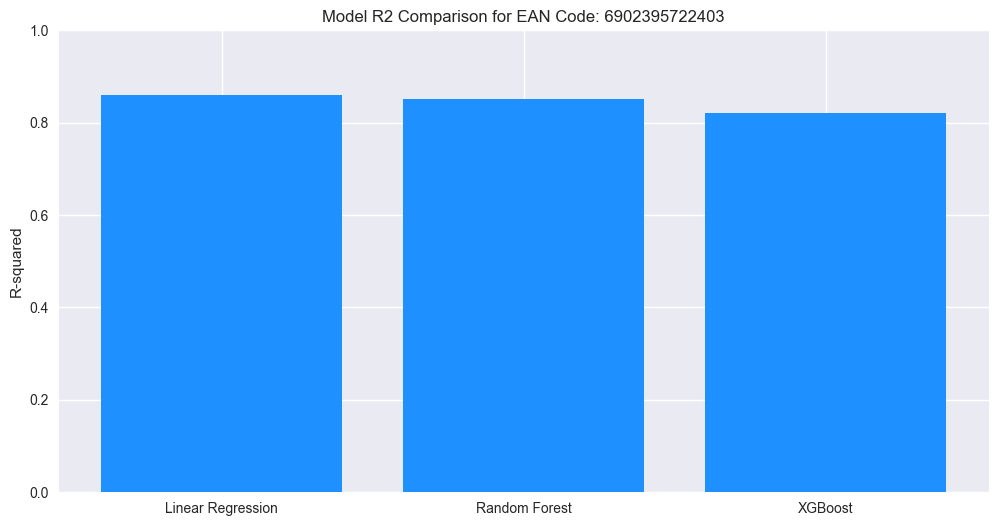

In [10]:
for product in top_products:
    prod_res = results_df[results_df['EAN_Code'] == product]
    plt.figure(figsize=(12,6))
    x = prod_res['Model']
    y = prod_res['R2']
    plt.bar(x, y, color='dodgerblue')
    plt.ylim(0, 1)
    plt.ylabel("R-squared")
    plt.title(f"Model R2 Comparison for EAN Code: {product}")
    plt.show()

 Forecast vs. Actuals Table

In [ ]:
for product in top_products:
    prod_res = results_df[results_df['EAN_Code'] == product]
    forecast_dates = test.index
    predictions_df = pd.DataFrame({
        'EAN_Code': product,
        'Actual': test['quantity'].values[:len(forecast_dates)],
        'Linear Regression': lr_pred,
        'Random Forest': rf_pred,
        'XGBoost': xgb_pred
    })
    print(predictions_df.round())